# Log clustering

This notebook is intended to adapt Maria's approach *word2vec + dbscan* to Rucio transfer errors.

## Import libraries 

In [1]:
import numpy as np
from kneed import KneeLocator
import nltk 
from nltk.tokenize import TreebankWordTokenizer
from gensim.models import Word2Vec
import math
# import pyonmttok
from sklearn.neighbors import NearestNeighbors
import daal4py
import re
import time
import logging
from statistics import mean, stdev
import matplotlib.pyplot as plt
import multiprocessing
from statistics import mean, stdev
from fuzzywuzzy import fuzz
import pandas as pd

## User defined functions 

In [2]:
def reader(fname):
    """
    Currently reader is implemented just as a reader from file
    :param fname:
    :return:
    """
    with open('errors.log') as my_file:
        errors = my_file.readlines()
    return list(map(lambda x: x.rstrip(), errors))

def remove_whitespaces(sentence):
    """
    Some error messages has multiple spaces, so we change it to one space.
    :param sentence:
    :return:
    """
    return " ".join(sentence.split())

def clear_strings(data):
    """
    Clear error messages from unnecessary data:
    - UID/UUID in file paths
    - line numbers - as an example "error at line number ..."
    Removed parts of text are substituted with titles
    :param data:
    :return:
    """
    _uid = r'[0-9a-zA-Z]{12,128}'
    _line_number = r'(at line[:]*\s*\d+)'
    _uuid = r'[a-f0-9]{8}-[a-f0-9]{4}-4[a-f0-9]{3}-[89aAbB][a-f0-9]{3}-[a-f0-9]{12}'

    for idx, item in enumerate(data):
        _cleaned = re.sub(_line_number, "at line LINE_NUMBER", item)
        _cleaned = re.sub(_uid, "UID", _cleaned)
        _cleaned = re.sub(_uuid, "UUID", _cleaned)
        data[idx] = remove_whitespaces(_cleaned)

def tokenization(errors):
    """
    Tokenization of a list of error messages.
    The best tokenizer for error messages is TreebankWordTokenizer (nltk).
    It's good at tokenizing file paths.
    :param errors:
    :return:
    """
    tokenized = []
    for line in errors:
        tokenized.append(TreebankWordTokenizer().tokenize(line))
    return tokenized

def pyonmttok_tokenization(data):
    """
    Alternative tokenizer. It performs much faster, but worse in tokenizing of paths.
    It splits all paths by "/".
    TODO: This method should be optimized to the same tokenization quality as TreebankWordTokenizer
    :param data:
    :return:
    """
    pyonmttok_tokens = []
    tokenizer = pyonmttok.Tokenizer("space", joiner_annotate=False, segment_numbers=False)
    for doc in data:
        tokens, features = tokenizer.tokenize(doc)
        pyonmttok_tokens.append(tokens)
    return pyonmttok_tokens

def train_word2vec(sentences, size=100, window=10, min_count=1, workers=4, iter=10):
    """
    Training word2vec model
    :param sentences: tokenized sentences
    :param size: size of the vector to represent each token
    :param window: max distance between target token and its neighbors
    :param min_count: minimium frequency count of words
    :param workers: number of CPUs
    :param iter:
    :return:
    """
    return Word2Vec(sentences, size=size, window=window, min_count=min_count, workers=workers, iter=iter)


def sentence2vec(sentences, model):
    """
    Calculates mathematical average of the word vector representations
    of all the words in each sentence
    :param sentences: tokenized
    :param model: word2vec model
    :return:
    """
    X=[]
    for sent in sentences:
        sent_vec =[]
        numw = 0
        for w in sent:
            try:
                if numw == 0:
                    sent_vec = model[w]
                else:
                    sent_vec = np.add(sent_vec, model[w])
                numw+=1
            except:
                pass

        X.append(np.asarray(sent_vec) / numw)
    return np.array(X)

def kneighbors(X):
    """
    Calculates average distances for k-nearest neighbors
    :param X:
    :return:
    """
    k = round(math.sqrt(len(X)))
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    if k > 2:
        avg_distances = []
        for line in distances:
            avg_distances.append(mean(line))
        return avg_distances
    else:
        return distances[:,1]

def epsilon_search(distances):
    """
    Search epsilon for DBSCAN
    :param distances:
    :return:
    """
    kneedle = KneeLocator(distances, list(range(len(distances))))
    return max(kneedle.all_elbows)

def distance_curve(distances):
    """
    Save distance curve with knee candidates in file.
    :param distances:
    :return:
    """
    sensitivity = [1, 3, 5, 10, 100, 150, 200]
    knees = []
    y = list(range(len(distances)))
    for s in sensitivity:
        kl = KneeLocator(distances, y, S=s)
        knees.append(kl.knee)

    plt.style.use('ggplot');
    plt.figure(figsize=(10, 10))
    plt.plot(distances, y)
    colors = ['r', 'g', 'k', 'm', 'c', 'b', 'y']
    for k, c, s in zip(knees, colors, sensitivity):
        plt.vlines(k, 0, len(distances), linestyles='--', colors=c, label=f'S = {s}')
    plt.legend()
    plt.show()
    print(knees)

def dbscan(X, epsilon, min_samples):
    """
    DBSCAN clusteing with daal4py library
    :param X:
    :param epsilon:
    :return: DBSCAN labels
    """
    algo = daal4py.dbscan(minObservations=min_samples, epsilon=epsilon,
                          resultsToCompute='computeCoreIndices|computeCoreObservations')
    result = algo.compute(X)
    return result.assignments[:, 0]


# Import data 

## Custom data: Rucio data transfers - deletion-failure

In [3]:
!pwd

/home/luca/workspace/rucio-log-clustering/notebooks


In [4]:
%%time

# read data downloaded through fetch_all_data.py
with open("../issues.json", 'r') as f:
    raw_data = json.load(f)

# reorganize them in a pandas dataframe structure    
errors = pd.DataFrame()
for page in raw_data:
    for record in page:
        idx = record.pop('id')
        temp = pd.DataFrame(record, index=[idx])
        errors = errors.append(temp)

CPU times: user 5.8 s, sys: 28.1 ms, total: 5.83 s
Wall time: 5.84 s


Extract just the information about log messages:

In [5]:
error_messages = errors.message

print("Total messages:", error_messages.shape, "\nTotal unique values:", len(error_messages.unique()))
      
error_messages.head()

Total messages: (2826,) 
Total unique values: 589


1    SOURCE [70] globus_xio: Unable to connect to a...
2    TRANSFER [70] TRANSFER  globus_xio: Unable to ...
3    TRANSFER [70] TRANSFER  globus_xio: Unable to ...
4    SOURCE [70] globus_xio: Unable to connect to a...
5    SOURCE [70] globus_xio: Unable to connect to a...
Name: message, dtype: object

We have less than 3k error messages, with 589 unique values.

# Preprocessing 

## Strings clearing

Let's now start with strings cleaning so to input them into the word2vec model:

In [6]:
clear_strings(error_messages)

/home/luca/anaconda3/envs/error-logs/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
error_messages

1       TRANSFER [70] TRANSFER globus_xio: Unable to c...
2       TRANSFER [70] TRANSFER globus_xio: Unable to c...
3       SOURCE [70] globus_xio: Unable to connect to a...
4       SOURCE [70] globus_xio: Unable to connect to a...
5       The requested service is not available at the ...
                              ...                        
2821    The requested service is not available at the ...
2822    TRANSFER [17] TRANSFER globus_ftp_client: the ...
2823    TRANSFER [110] TRANSFER Transfer canceled beca...
2824    TRANSFER [110] TRANSFER Transfer canceled beca...
2825    TRANSFER [110] TRANSFER Transfer canceled beca...
Name: message, Length: 2926, dtype: object

<div class="alert alert-block alert-danger">
<b>Alert:</b> This step apparently introduces 100 rows wrt the initial dataset (2926 instead of 2826):
    
   --> check what is actually happening
</div>

## Tokenization 

In [9]:
tokenized = tokenization(error_messages)

In [10]:
len(tokenized), tokenized

(2926,
 [['TRANSFER',
   '[',
   '70',
   ']',
   'TRANSFER',
   'globus_xio',
   ':',
   'Unable',
   'to',
   'connect',
   'to',
   'atlas-gridftp.bu.edu:2811',
   'globus_xio',
   ':',
   'globus_libc_getaddrinfo',
   'failed.',
   'globus_common',
   ':',
   'Temporary',
   'failure',
   'in',
   'name',
   'resolution'],
  ['TRANSFER',
   '[',
   '70',
   ']',
   'TRANSFER',
   'globus_xio',
   ':',
   'Unable',
   'to',
   'connect',
   'to',
   'atlas-gridftp.bu.edu:2811',
   'globus_xio',
   ':',
   'globus_libc_getaddrinfo',
   'failed.',
   'globus_common',
   ':',
   'Temporary',
   'failure',
   'in',
   'name',
   'resolution'],
  ['SOURCE',
   '[',
   '70',
   ']',
   'globus_xio',
   ':',
   'Unable',
   'to',
   'connect',
   'to',
   'atlas-gridftp.bu.edu:2811',
   'globus_xio',
   ':',
   'globus_libc_getaddrinfo',
   'failed.',
   'globus_common',
   ':',
   'Name',
   'or',
   'service',
   'not',
   'known'],
  ['SOURCE',
   '[',
   '70',
   ']',
   'globus_xio',


<div class="alert alert-block alert-danger">
<b>Alert:</b> The tokenization is not optimal for  our use case and has to be double checked for data transfers (created for job logs).
    
For example, in `TRANSFER [70] TRANSFER` the block `[70]` is separated as the single brackets and the number, while it makes sense to keep it as a unique token.
</div>

# Word2vec

The following cell trains a **word2vec** model using *CBOW* and *Skip-gram* models to infer, respectively, the current work given the context (window) and the context given the current word. The aim in doing this is to get a representation of the words/tokens in the vocabulary in a different, more convenient space (**word embedding**).

We use a *200-dimensional* space as target representation (**size**) with a context of size up to 10, i.e. the 5 words before plus the 5 words after the current word (**window**).

Also, we do not exclude any of the words/tokens of the vocabulary, i.e. we retain rare words (**min_count**).

<div class="alert alert-block alert-info">
<b>Note:</b> 
    The gensim implementation of word2vec runs on CPUs, so make sure to configure the argument <i>workers</i> according to your system.
</div>

In [16]:
%%time
_word2vec = train_word2vec(tokenized, size=200, window=5, min_count=1, workers=10, iter=1000)

CPU times: user 1min 20s, sys: 1.4 s, total: 1min 22s
Wall time: 26.5 s


In [17]:
_word2vec.__dict__

{'max_final_vocab': None,
 'callbacks': (),
 'load': <function gensim.utils.call_on_class_only(*args, **kwargs)>,
 'wv': <gensim.models.keyedvectors.Word2VecKeyedVectors at 0x7fc903f2cc88>,
 'vocabulary': <gensim.models.word2vec.Word2VecVocab at 0x7fc903f2cc50>,
 'trainables': <gensim.models.word2vec.Word2VecTrainables at 0x7fc903f2cc18>,
 'sg': 0,
 'alpha': 0.025,
 'window': 5,
 'random': RandomState(MT19937) at 0x7FC903F1C048,
 'min_alpha': 0.0001,
 'hs': 0,
 'negative': 5,
 'ns_exponent': 0.75,
 'cbow_mean': 1,
 'compute_loss': False,
 'running_training_loss': 0.0,
 'min_alpha_yet_reached': 0.00010215300751879527,
 'corpus_count': 2926,
 'corpus_total_words': 87725,
 'vector_size': 200,
 'workers': 10,
 'epochs': 1000,
 'train_count': 1,
 'total_train_time': 21.43392521570422,
 'batch_words': 10000,
 'model_trimmed_post_training': False}

In [19]:
print("length of the vocabulary used:", len(_word2vec.wv.__dict__["vocab"]))

length of the vocabulary used: 879


## Sentence2vec

Once we have trained the word2vec model, then we have to find a way to represent not just words/tokens but entire log messages into the embedded space. 

The simple approach adopted in the following is to simply average the 200-dimensional representation of the tokens composing each message and use the single results to represent the whole sentence.

In [20]:
_sent2vec = sentence2vec(tokenized, _word2vec)

/home/luca/anaconda3/envs/error-logs/lib/python3.6/site-packages/ipykernel_launcher.py:95: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/luca/anaconda3/envs/error-logs/lib/python3.6/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [25]:
len(_sent2vec), len(_sent2vec[0])

(2926, 200)

The length of the sentence2vec is the same as the number of rows of the initial (cleared) dataset, while the length of each of its elements is 200. In fact, each of the original error logs is converted into the 200-dimensional representation extracted through the word2vec model.

# Density Based Spatial Clustering of Applications with Noise (DBSCAN)

Once we have found a convenient embedded space in which tokens, and consequently messages, are hopefully well represented/separated, then it is time to proceed with the application of a clustering strategy to detect common failure patterns.

In the following, DBSCAN algorithm is adopted. The first step is to detect automatically the values for its hyperparameters:
- **MinPts:** minimum number of points present in the neighbourhood for the *core point* condition
- $ \boldsymbol \epsilon$**:** size of the neighbourhood

## Hyperparameter: $\epsilon$

In order to find the value for the hyperparameter $\epsilon$, we can use the so-called k-sorted-neighbours graph, which plots the ordered distance of the first k closest neighbours for each point. 

The optimal value for $\epsilon$ is then retrieved as the sharpest elbow in the plot.

<div class="alert alert-block alert-info">
    <b>Note:</b> The value of <b>k is set to $\sqrt{ n}$ </b> as a rule of thumb.
</div>

### Debug error K-NN 

In [ ]:
def kneighbors(X):
    """
    Calculates average distances for k-nearest neighbors
    :param X:
    :return:
    """
    k = round(math.sqrt(len(X)))
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    if k > 2:
        avg_distances = []
        for line in distances:
            avg_distances.append(mean(line))
        return avg_distances
    else:
        return distances[:,1]

In [26]:
type(_sent2vec), len(_sent2vec)

(numpy.ndarray, 2926)

In [27]:
c = 0
for el in _sent2vec:
    if not len(el):
        c += 1
c

38

<div class="alert alert-block alert-danger">
<b>Alert:</b> There are actually 38 empty messages (presumably introduced by the clearing) that have to be discarded to avoid problems in the KNN step below. 
</div>

In [29]:
X = []

for el in _sent2vec:
    if len(el)!=0:
        X.append(el)

In [30]:
k = round(math.sqrt(len(X)))
neigh = NearestNeighbors(n_neighbors=k)

nbrs = neigh.fit(list(X))
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
if k > 2:
    avg_distances = []
    for line in distances:
        avg_distances.append(mean(line))
#     return avg_distances
# else:
#     return distances[:,1]

<div class="alert alert-block alert-success">
<b>SOLUTION:</b> it seems that the problem is in elements of _sent2vec that have 0 length
    
    --> check better!
</div>

### End Debug 

In [33]:
# Get only the non-empty messages
X = []

for el in _sent2vec:
    if len(el)!=0:
        X.append(el)
        
# compute the KNN distances
distances = kneighbors(X)

In [32]:
distances

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

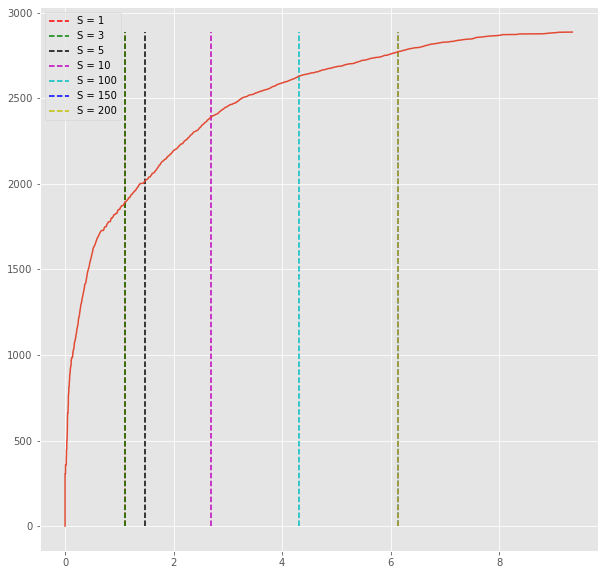

[1.1039053074863854, 1.1039053074863854, 1.4819723380986503, 2.6821896025761793, 4.308426023145334, 6.137542761659066, 6.137542761659066]


In [34]:
# plot the k-sorted-neighbours graph for optimal espilon detection
knees = distance_curve(distances)

In [38]:
%%time

epsilon = epsilon_search(distances)

print("A proposal for the optimal value for epsilon is:", epsilon, "\n")

A proposal for the optimal value for epsilon is: 7.552940267491171 

CPU times: user 3.31 ms, sys: 3.83 ms, total: 7.15 ms
Wall time: 6.39 ms


In [72]:
%%time
cluster_labels = dbscan(X, 20, 5)

# try to tune the MinPts parameter to get a reasonable number of clusters
# intended_number_of_clusters = 6

# for i in range(2000):
#     cluster_labels = dbscan(X, epsilon, i)
#     if len(np.unique(cluster_labels))== intended_number_of_clusters:
#         break

cluster_labels

CPU times: user 44.1 ms, sys: 0 ns, total: 44.1 ms
Wall time: 43.2 ms


array([-1, -1, -1, -1,  0, -1,  0, -1, -1,  0,  0, -1, -1, -1,  0, -1,  0,
        2, -1,  0, -1, -1, -1,  0, -1,  0, -1,  0, -1,  0,  0, -1, -1,  0,
       -1, -1, -1,  0, -1, -1,  0, -1,  0,  0,  0, -1, -1, -1,  2, -1, -1,
        0,  1, -1, -1,  0, -1,  0,  2, -1, -1, -1, -1, -1, -1,  0, -1,  0,
        0, -1, -1,  0,  0,  0, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
        0,  0, -1, -1, -1, -1,  0, -1,  0,  0, -1, -1, -1,  0, -1, -1, -1,
       -1, -1,  0,  0,  0, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1, -1,
       -1, -1, -1,  0, -1,  0, -1, -1, -1, -1,  2,  0,  1, -1, -1,  0, -1,
       -1, -1,  0, -1, -1, -1,  0, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1,
        1, -1,  1, -1,  0,  0, -1, -1, -1,  0,  1, -1, -1, -1, -1, -1,  0,
        1, -1,  2, -1,  2, -1, -1, -1, -1, -1,  0, -1,  0, -1,  0,  0,  0,
       -1,  2, -1,  2,  0, -1, -1,  0, -1, -1, -1, -1, -1], dtype=int32)

In [74]:
print("Output number of clusters:", np.unique(cluster_labels)-1)
print("The cluster labelled -1 is for outliers. In total:", len(cluster_labels[cluster_labels==-1]))

Output number of clusters: [-2 -1  0  1]
The cluster labelled -1 is for outliers. In total: 127


<div class="alert alert-block alert-danger">
<b>Alert:</b> I don't think this piece is working. It seems it is clustering the dimensions based on the messages rather than the opposite (indeed we have 200  association with a cluster label).
</div>

## Clusters visualisation 

To refine based on the previous outputs.

In [ ]:
def print_clusters(ds, labels):
    results = {}
    for label in set(labels):
        elements = []
        for idx, l in enumerate(labels):
            if l == label:
                elements.append(ds[idx])
        results[label] = elements
    return results

In [ ]:
def print_cluster(data, labels, cluster_label):
    results = []
    for idx, l in enumerate(labels):
        if l == cluster_label:
            results.append(data[idx])
    return results

In [ ]:
def cluster_stats(cluster_results):
    clusters = []
    for item in cluster_results:
        cluster = {}
        cluster["cluster_name"] = item
        cluster["first_entry"] = cluster_results[item][0]
        cluster["cluster_size"] = len(cluster_results[item])
        lengths = []
        for s in cluster_results[item]:
            lengths.append(len(s))
        mean_length = mean(lengths)
        try:
            std_length = stdev(lengths)
        except:
            std_length = 0
        cluster["mean_length"] = mean_length
        cluster["std_lengt"] = std_length
        dist = []
        x0 = cluster_results[item][0]
        for i in range(0,len(cluster_results[item])):
            x = cluster_results[item][i]
            dist.append(fuzz.ratio(x0,x))
        cluster["mean_similarity"] = mean(dist)
        try:
            cluster["std_similarity"] = stdev(dist)
        except:
            cluster["std_similarity"] = 0
        clusters.append(cluster)
    clusters_df = pd.DataFrame(clusters)
    return clusters_df.sort_values(by=['mean_similarity'])

In [ ]:
### RETRIEVE JUST THE ERRORS THAT DO NOT RESULT IN 0 LENGHT SENT2VEC

X_err = []

for i, el in enumerate(_sent2vec):
    if len(el):
        X_err.append(error_messages.iloc[i])

clustered_errors = print_clusters(X_err, cluster_labels)

In [ ]:
df = cluster_stats(clustered_errors)

In [ ]:
df

In [ ]:
df.iloc[127].first_entry

In [ ]:
df.cluster_size.describe()

In [ ]:
df.iloc[128].first_entry

In [ ]:
df.first_entry[3]

In [ ]:
df.first_entry[2]

In [ ]:
print_cluster(errors, cluster_labels, 16)

In [ ]:
print_cluster(errors, cluster_labels, 16)